# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics
from torchinfo import summary
sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [2]:
# Device agnostig code
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Device is {device}")

if device=="cuda":
    PIN_MEMORY = True
    NUM_WORKERS = 4
    PERSISTANT_WORKERS = True
else:
    PIN_MEMORY = False
    NUM_WORKERS = 0
    PERSISTANT_WORKERS = False
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=NUM_WORKERS,
                                                                                           pin_memory=PIN_MEMORY,
                                                                                           persistent_workers = PERSISTANT_WORKERS)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True,num_workers=NUM_WORKERS,
                                                                                        pin_memory=PIN_MEMORY,
                                                                                        persistent_workers = PERSISTANT_WORKERS)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Device is mps


100%|██████████| 170498071/170498071 [00:09<00:00, 17950094.44it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

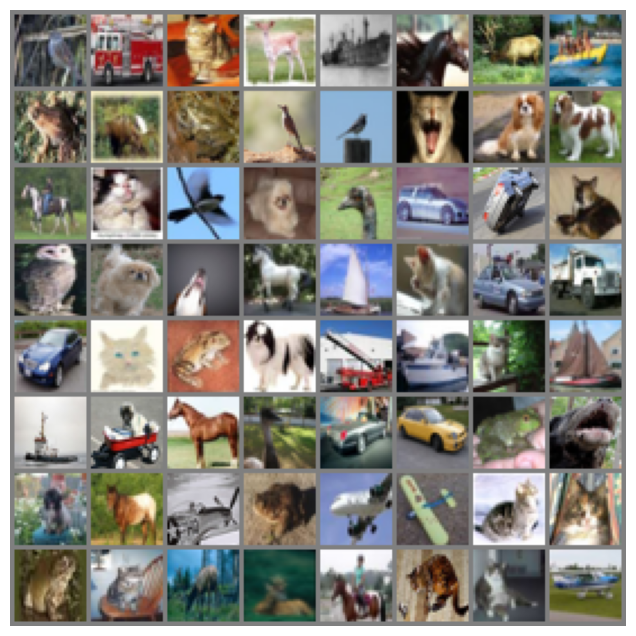

In [4]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [5]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.conv = nn.Sequential(nn.Conv2d(in_channels=3,
                                              out_channels=32,
                                              kernel_size=3,
                                              stride=1,
                                              padding=1),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2,2),
                                    nn.Conv2d(in_channels=32,
                                              out_channels=64,
                                              kernel_size=3,
                                              stride=1,
                                              padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=64,
                                              out_channels=128,
                                              kernel_size=3,
                                              stride=1,
                                              padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2,2),
                                    nn.Conv2d(in_channels=128,
                                              out_channels=64,
                                              kernel_size=3,
                                              stride=1,
                                              padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU()
                                    )
        self.fc = nn.Sequential(nn.Flatten(),
                                nn.Linear(in_features=64*8*8,out_features=num_classes))
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


model = Model(n_classes)
model.to(device)
print(model)

Model(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Li

## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [6]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [7]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32,device = device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[ 0.6244346  -0.34918863  0.0633026   0.09247924 -0.1889729   0.4952367
   0.26247242 -0.84501886  0.24098355 -0.37369174]
 [ 0.75553906 -1.2550561   0.45892087 -0.5522958  -0.1438335  -0.09788811
   0.10040671  0.18150191  0.13492392 -0.7382261 ]]
Output probabilities:
[[0.17139989 0.06473979 0.0977944  0.10068974 0.07598924 0.15062621
  0.11934723 0.03943074 0.11680994 0.06317274]
 [0.20724623 0.02775212 0.15405187 0.05604039 0.0843129  0.08827707
  0.10763816 0.1167308  0.11141839 0.0465321 ]]


In [8]:
batch_size = 64
num_epochs = 10
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    print(f"epoch: {epoch}")
    train_accuracies_batches = []
    
    for inputs, targets in (train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        # Forward pass, compute gradients, perform one training step.
        output = model(inputs)
        loss = loss_fn(output,targets)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"batch {step:<5}   training accuracy: {train_accuracies[-1]:.4f}")
            print(f"             test accuracy: {valid_accuracies[-1]:.4f}")

print("Finished training.")

epoch: 0
batch 500     training accuracy: 0.5651
             test accuracy: 0.6552
epoch: 1
batch 1000    training accuracy: 0.7304
             test accuracy: 0.7004
batch 1500    training accuracy: 0.7367
             test accuracy: 0.7281
epoch: 2
batch 2000    training accuracy: 0.7815
             test accuracy: 0.7347
epoch: 3
batch 2500    training accuracy: 0.8307
             test accuracy: 0.7480
batch 3000    training accuracy: 0.8154
             test accuracy: 0.7581
epoch: 4
batch 3500    training accuracy: 0.8492
             test accuracy: 0.7690
epoch: 5
batch 4000    training accuracy: 0.8896
             test accuracy: 0.7775
batch 4500    training accuracy: 0.8748
             test accuracy: 0.7695
epoch: 6
batch 5000    training accuracy: 0.9044
             test accuracy: 0.7796
epoch: 7
batch 5500    training accuracy: 0.9171
             test accuracy: 0.7941
batch 6000    training accuracy: 0.9214
             test accuracy: 0.7888
epoch: 8
batch 6500    train

## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

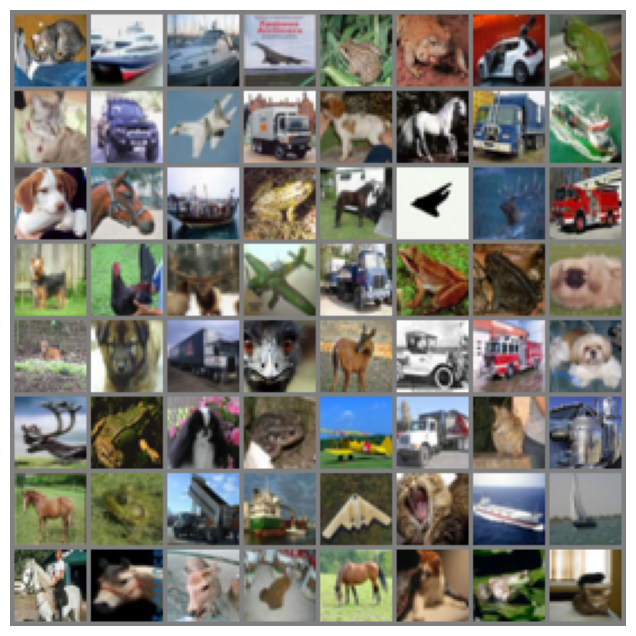

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship          ship     
    ship          ship     
  airplane      airplane   
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog          bird     
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog           dog     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse         horse    
    ship          ship     
    frog          frog     
    horse         horse    
  airplane      airplane   
    deer          deer     
    truck         truck    
     dog          deer     
    bird          deer     
    deer          deer     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog           dog     
    deer          bird     
     dog           d

In [9]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

### Sometimes this cell underneath doesn't run, because of the way the dataloader randomly shuffles the data. In that case, the entire notebook should be restarted and run again, sorry.

In [10]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [11]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.784


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


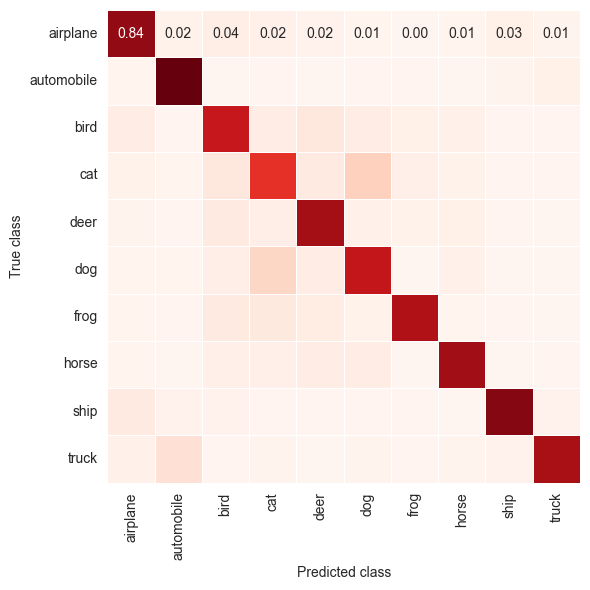

In [12]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

/Users/markus/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


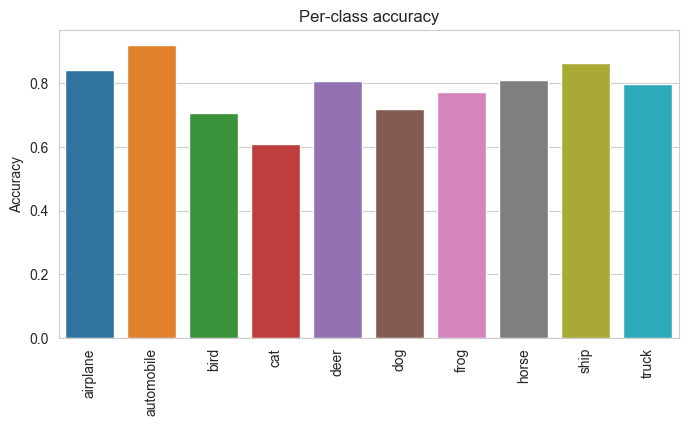

In [13]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.

**Answer:**

I have improved the original network by adding more and bigger layers, adding batchnorm and maxpool.

# Training on GPU

if you have a GPU to use, then the code uses that. This is done in the beginning (python cell nr. 2) marked by "# device agnostic code"

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

**Answer:**





### verify that : $\sigma^{\prime}(z)=\sigma(z)(1-\sigma(z))$

The sigma function is given by:
$$

\sigma(z) = \frac{1}{1+e^{-z}}

$$


By using the chain rule we get:
$$
\begin{equation}
\frac{\partial \sigma(z)}{\partial z} = (1+e^{-z})^{-2} \cdot (e^{-z}) = \sigma(z)^2 \cdot e^{-z}.
\end{equation}
$$

Now we need so solve for $ e^{-z} $ in the definition of the sigma-function:

$$
\sigma(z) = \frac{1}{1+e^{-z}} \\
\updownarrow \\
\sigma(z) \cdot (1+e^{-z}) = 1 \\ 
\updownarrow \\
(1+e^{-z}) = \frac{1}{\sigma(z)} \\ 
\updownarrow \\
e^{-z} = \frac{1}{\sigma(z)}-1 = \frac{1-\sigma(z)}{\sigma(z)}
$$

inserting this in $(1)$ we get:

$$
\frac{\partial \sigma(z)}{\partial z} = \sigma(z)^2 \cdot e^{-z} = \sigma(z)^2 \cdot  \frac{1-\sigma(z)}{\sigma(z)} = \sigma(z) \cdot (1-\sigma(z))
$$

So $\sigma^{\prime}(z)=\sigma(z)(1-\sigma(z))$